In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/labs/amit/noamsh/repos/MM_2023')

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
from clinical_predictions.clinical_data_loading import generate_refracrotines_dataset 
from clinical_predictions.utils import balanced_subsample

In [4]:
from clinical_predictions.evaluation import train_and_eval_model, generate_datasets_summerization

In [39]:
from functools import partial

import optuna
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split, cross_validate
from sklearn.feature_selection import SequentialFeatureSelector
from xgboost import XGBClassifier
import sklearn

def objective(trial, X_train, y_train):
    use_feature_selection = False
    classifier_name = trial.suggest_categorical('classifier', ['XGBoost', 'LogisticRegression'])# ['LogisticRegression']) # ['RandomForest', 'XGBoost', 'LogisticRegression'])
    if classifier_name == 'SVC':
         svc_c = trial.suggest_float('svc_c', 1e-1, 1e3, log=True)
         model = sklearn.svm.SVC(C=svc_c, gamma='auto')
    elif classifier_name == 'RandomForest':
        rf_max_depth = trial.suggest_int('rf_max_depth', 2, 32, log=True)
        rf_n_estimators = trial.suggest_int('rf_n_estimators', 2, 16, log=True)
        model = sklearn.ensemble.RandomForestClassifier(max_depth=rf_max_depth, n_estimators=rf_n_estimators)
    elif classifier_name == 'LogisticRegression':
        # use_feature_selection = True
        logistic_regression_c = trial.suggest_float('logistic_regression_c', 1e-4, 1e1, log=True)
        logr_penalty = trial.suggest_categorical('logr_penalty', ["l1", "l2"])
        model = sklearn.linear_model.LogisticRegression(C=logistic_regression_c, penalty=logr_penalty, solver='liblinear')
    else:
        param = {
            'booster': trial.suggest_categorical('xgb_booster', ['gbtree', 'dart']),
            'n_estimators': trial.suggest_int('xgb_n_estimators', 2, 16, log=True), 
            'max_depth': trial.suggest_int('xgb_max_depth', 1, 4), 
            # 'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True)
        }
        model = XGBClassifier(**param)
        
    # subsample = trial.suggest_categorical('subsample', [True, False])
    # if subsample:
    #     subsample_indexs = balanced_subsample(y_train)
    #     X_train = X_train.loc[subsample_indexs]
    #     y_train = y_train.loc[subsample_indexs]
    
    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
    
    if use_feature_selection:
        fix_feature_selection = trial.suggest_categorical('fix_feature_selection', [True, False])
        n_features_to_select = 'auto'
        if fix_feature_selection:
            alpha_features_to_select = trial.float("alpha_features_to_select", 0.1, 0.9)
        sfs = SequentialFeatureSelector(model, scoring='f1_weighted', n_features_to_select=alpha_features_to_select, cv=cv, n_jobs=4)
        X_train = sfs.fit_transform(X_train, y_train)
    
    scores = cross_validate(model, X_train, y_train, cv=cv, scoring = ['accuracy', 'precision', 'f1', 'f1_weighted', 'f1_macro'])
    prec_alpha = 0.8
    mean_f1_prec_score = np.mean(scores['test_f1_weighted']  + scores['test_precision'] * prec_alpha)
    
    trial.set_user_attr(key="best_booster", value=model)
    return mean_f1_prec_score


def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])


def get_best_model_with_optuna(X_train, y_train, n_trials=30):
    study = optuna.create_study(direction='maximize')
    study.optimize(partial(objective, X_train=X_train, y_train=y_train), n_trials=n_trials, callbacks=[callback])
    best_model = study.user_attrs["best_booster"]
    best_trail = study.best_trial
    return best_model, best_trail

## loading

In [40]:
dataset_path = '/home/labs/amit/noamsh/repos/MM_2023/notebooks/tmp_data/zstat_MARS_SPID_20231130/MARS_SPID_exp_clin_nmf.xlsx'
raw_hospital_path = '/home/labs/amit/noamsh/repos/MM_2023/notebooks/tmp_data/zstat_MARS_SPID_20231130/Annonymized_CRF_BP_14112023S_SYW.xlsx'

In [41]:
raw_dataset = pd.read_excel(dataset_path)
raw_hospital_dataset = pd.read_excel(raw_hospital_path)
print(raw_dataset.shape)
# raw_dataset.head()

/home/labs/amit/noamsh/.conda/envs/sc_clustering_noam/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:221: UserWarning:

Workbook contains no default style, apply openpyxl's default



(262, 539)


In [42]:
print(raw_hospital_dataset.shape)
# raw_hospital_dataset.head()

(211, 111)


## general data filter

In [43]:
from clinical_predictions.clinical_data_loading import merge_transcriptom_data_to_raw_hospital

# remove no-transcriptom patients
# add post treatment columns from hospital
# add data to TAL_3 patients

dataset = merge_transcriptom_data_to_raw_hospital(raw_dataset, raw_hospital_dataset)

In [44]:
# path = '/home/labs/amit/noamsh/repos/MM_2023/notebooks/tmp_data/zstat_MARS_SPID_20231130/MARS_SPID_merged_with_hospital_231203.xlsx'
# dataset.to_excel(path)

### features selection

In [45]:
fish_cols = [col for col in raw_hospital_dataset.columns if "t(" in col or "del(" in col or col in ['1q21+', 'IGH rearrangement', 'Cytogenetics Risk (0=standard risk, 1=single hit, 2=2+ hits)']]
print(raw_hospital_dataset.shape)
dataset[fish_cols] = dataset[fish_cols].fillna(-1)
pd.concat([dataset[fish_col].value_counts().rename(fish_col) for fish_col in fish_cols], axis=1)

(211, 111)


,1q21+,del(1p),del(13q),del(17p),t(11:14),t(4:14),t(14:16),t(14:20),IGH rearrangement,"Cytogenetics Risk (0=standard risk, 1=single hit, 2=2+ hits)"
-1.0,54.0,55.0,57.0,54.0,53.0,54.0,56.0,59.0,59.0,59.0
1.0,41.0,13.0,17.0,21.0,25.0,7.0,3.0,1.0,20.0,26.0
0.0,40.0,67.0,61.0,60.0,57.0,74.0,76.0,75.0,56.0,NaN
2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.0
3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0


In [46]:
nmf_features = [f"X{i + 1}" for i in range(6)]
npc_composition = ["B", "B_Pro", "DC", "DC_IRF8", "Erythrocytes", "Fibro", "Mast", "Mf", "Mo", "Mo_CD16", "Neu_Pro",
                   "NK", "pDC", "T_Effector", "T_Effector_GZMB", "T_Naive", "UN"]
fish_cols = [col for col in raw_hospital_dataset.columns if "t(11:14)" == col or "del(" in col or col in ['1q21+', 'IGH rearrangement', 'Cytogenetics Risk (0=standard risk, 1=single hit, 2=2+ hits)']]

feats = nmf_features # + fish_cols
# feats = fish_cols

In [47]:
cols_series = pd.Series(raw_dataset.columns)
genes_start_index = cols_series[cols_series == 'Transcriptom'].index[0] + 1
genes_end_index = cols_series[cols_series == 'Stage'].index[0] 
genes_cols = cols_series.iloc[genes_start_index: genes_end_index]
feats += list(genes_cols)


### label selection

In [48]:
datasets = {}
for treatment in ["Carfilzomib", "Lenalidomide", "Pomalidomide", "DARA", "CART", "Bortezomib", "Belantamab"]:

    if treatment == "CART":
        non_ref_policy = "NDMM-POST_TREATMENT_REF"
    else:
        non_ref_policy = "NDMM"

    # non_ref_policy = "NON_EXPOSED"

    X,y = generate_refracrotines_dataset(dataset, treatment, non_ref_policy, feats)
    
    datasets[treatment] = (X, y)

In [49]:
for group in ["Triple.Ref" ,"Triple.Exp" ,"Penta.Ref" ,"Penta.Exp" ,"IMiD.Resistance.Len.Pom.Thali" ,"PI.Resistance.Bort.Carf.Ixa" ]:
    dataset_copy = dataset.copy()
    mask = ~ dataset_copy[group].isna()
    X = dataset_copy[mask][feats]
    y = dataset_copy[mask][group] == 1
    y = y.astype(int)

    datasets[group] = (X, y)

In [50]:
pd.concat([y.value_counts().rename(treatment) for treatment, (_, y) in datasets.items()], axis=1)

,Carfilzomib,Lenalidomide,Pomalidomide,DARA,CART,Bortezomib,Belantamab,Triple.Ref,Triple.Exp,Penta.Ref,Penta.Exp,IMiD.Resistance.Len.Pom.Thali,PI.Resistance.Bort.Carf.Ixa
0,24,24,24,24,40,24,24,82,71,105,95,63,55
1,20,60,31,46,3,51,7,28,39,5,15,47,55


In [51]:
good_treatments_data_sets = ["Bortezomib", "Carfilzomib", "Lenalidomide", "Pomalidomide", "DARA"] + ["Triple.Ref", "IMiD.Resistance.Len.Pom.Thali" ,"PI.Resistance.Bort.Carf.Ixa" ]

## model training

In [52]:
from sklearn.model_selection import train_test_split, GridSearchCV

good_splited_datasets = {}

for treatment in good_treatments_data_sets:
    X, y = datasets[treatment]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    good_splited_datasets[treatment] = X_train, X_test, y_train, y_test


In [53]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, Lasso

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.svm import SVC

monitor = {}

for treatment in tqdm(good_splited_datasets):
    X_train, X_test, y_train, y_test = good_splited_datasets[treatment]
    model, best_trial = get_best_model_with_optuna(X_train, y_train, n_trials=30)
    monitor[treatment] = train_and_eval_model(X_train, X_test, y_train, y_test, model, extra_for_report=best_trial.params)


  0%|          | 0/8 [00:00<?, ?it/s][I 2023-12-07 22:30:01,678] A new study created in memory with name: no-name-ba29cf68-3c78-460d-91e5-01d69dcf9b03
[I 2023-12-07 22:30:01,730] Trial 0 finished with value: 1.0892886993654258 and parameters: {'classifier': 'LogisticRegression', 'logistic_regression_c': 4.100400792933629, 'logr_penalty': 'l1'}. Best is trial 0 with value: 1.0892886993654258.
[I 2023-12-07 22:30:01,781] Trial 1 finished with value: 1.1646328671328672 and parameters: {'classifier': 'LogisticRegression', 'logistic_regression_c': 0.0034956998471440287, 'logr_penalty': 'l2'}. Best is trial 1 with value: 1.1646328671328672.
[I 2023-12-07 22:30:01,829] Trial 2 finished with value: 1.0614021473695385 and parameters: {'classifier': 'LogisticRegression', 'logistic_regression_c': 0.00038226013250850985, 'logr_penalty': 'l2'}. Best is trial 1 with value: 1.1646328671328672.
[I 2023-12-07 22:30:02,800] Trial 3 finished with value: 0.95777020138519 and parameters: {'classifier': 'XG

In [54]:
generate_datasets_summerization(monitor)

,1_y_train,0_y_train,1_y_test,0_y_test,1_y_pred,0_y_pred,precision_report,recall_report,f1-score_report,support_report,accuracy_report,precision_baseline,recall_baseline,f1-score_baseline,support_baseline,accuracy_baseline,model,extra
Bortezomib,34,18,17,6,20,3,0.800000,0.941176,0.864865,17.0,0.782609,0.705882,0.705882,0.705882,17.0,0.565217,"LogisticRegression(C=5.502004429600403, solver...","{'classifier': 'LogisticRegression', 'logistic..."
Carfilzomib,14,16,6,8,6,8,0.833333,0.833333,0.833333,6.0,0.857143,0.500000,0.666667,0.571429,6.0,0.571429,"XGBClassifier(base_score=None, booster='dart',...","{'classifier': 'XGBoost', 'xgb_booster': 'dart..."
Lenalidomide,40,18,20,6,18,8,0.777778,0.700000,0.736842,20.0,0.615385,0.789474,0.750000,0.769231,20.0,0.653846,"LogisticRegression(C=1.02625866098346, penalty...","{'classifier': 'LogisticRegression', 'logistic..."
Pomalidomide,22,16,9,8,9,8,0.888889,0.888889,0.888889,9.0,0.882353,0.533333,0.888889,0.666667,9.0,0.529412,"LogisticRegression(C=5.505053338271812, penalt...","{'classifier': 'LogisticRegression', 'logistic..."
DARA,32,17,14,7,15,6,0.800000,0.857143,0.827586,14.0,0.761905,0.571429,0.571429,0.571429,14.0,0.428571,"LogisticRegression(C=0.5398110952583985, solve...","{'classifier': 'LogisticRegression', 'logistic..."
Triple.Ref,21,56,7,26,4,29,0.500000,0.285714,0.363636,7.0,0.787879,0.272727,0.428571,0.333333,7.0,0.636364,"XGBClassifier(base_score=None, booster='gbtree...","{'classifier': 'XGBoost', 'xgb_booster': 'gbtr..."
IMiD.Resistance.Len.Pom.Thali,36,41,11,22,10,23,0.500000,0.454545,0.476190,11.0,0.666667,0.111111,0.090909,0.100000,11.0,0.454545,"LogisticRegression(C=0.4547621452980507, solve...","{'classifier': 'LogisticRegression', 'logistic..."
PI.Resistance.Bort.Carf.Ixa,43,34,12,21,22,11,0.454545,0.833333,0.588235,12.0,0.575758,0.444444,0.666667,0.533333,12.0,0.575758,"XGBClassifier(base_score=None, booster='dart',...","{'classifier': 'XGBoost', 'xgb_booster': 'dart..."


In [55]:
list(generate_datasets_summerization(monitor)["extra"])

["{'classifier': 'LogisticRegression', 'logistic_regression_c': 5.502004429600403, 'logr_penalty': 'l2'}",
 "{'classifier': 'XGBoost', 'xgb_booster': 'dart', 'xgb_n_estimators': 9, 'xgb_max_depth': 3}",
 "{'classifier': 'LogisticRegression', 'logistic_regression_c': 1.02625866098346, 'logr_penalty': 'l1'}",
 "{'classifier': 'LogisticRegression', 'logistic_regression_c': 5.505053338271812, 'logr_penalty': 'l1'}",
 "{'classifier': 'LogisticRegression', 'logistic_regression_c': 0.5398110952583985, 'logr_penalty': 'l2'}",
 "{'classifier': 'XGBoost', 'xgb_booster': 'gbtree', 'xgb_n_estimators': 15, 'xgb_max_depth': 1}",
 "{'classifier': 'LogisticRegression', 'logistic_regression_c': 0.4547621452980507, 'logr_penalty': 'l2'}",
 "{'classifier': 'XGBoost', 'xgb_booster': 'dart', 'xgb_n_estimators': 15, 'xgb_max_depth': 2}"]

## train a stage model

In [56]:
mask = ~ dataset["Stage"].isna()
X_stage = dataset[mask][feats]
y_stage = dataset[mask]["Stage"]
y_is_stage_3 = (y_stage == 3).astype(int)
y_0_is_1 = y_stage.apply(lambda x: x if x == 0 else x-1).astype(int)
y_stage.value_counts()

Stage
3.0    98
2.0    17
1.0     7
0.0     3
Name: count, dtype: int64

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_stage, y_is_stage_3, test_size=0.2, random_state=42)

model, best_trial = get_best_model_with_optuna(X_train, y_train, n_trials=50)

monitor_stage = {}
monitor_stage["Stage"] = train_and_eval_model(X_train, X_test, y_train, y_test, model)
print(best_trial.params)

[I 2023-12-07 22:31:36,097] A new study created in memory with name: no-name-8842a7c1-8ba0-47f6-aa81-235edec483ad
/home/labs/amit/noamsh/.conda/envs/sc_clustering_noam/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/home/labs/amit/noamsh/.conda/envs/sc_clustering_noam/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/home/labs/amit/noamsh/.conda/envs/sc_clustering_noam/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/home/labs/amit/noamsh/.conda/envs/sc_clusteri

{'classifier': 'LogisticRegression', 'logistic_regression_c': 0.022238791021191934, 'logr_penalty': 'l2'}


In [58]:
generate_datasets_summerization(monitor_stage)

,1_y_train,0_y_train,1_y_test,0_y_test,1_y_pred,0_y_pred,precision_report,recall_report,f1-score_report,support_report,accuracy_report,precision_baseline,recall_baseline,f1-score_baseline,support_baseline,accuracy_baseline,model,extra
Stage,78,22,20,5,21,4,0.809524,0.85,0.829268,20.0,0.72,0.85,0.85,0.85,20.0,0.76,"LogisticRegression(C=0.022238791021191934, sol...",


In [59]:
monitor_stage["Stage"].model

LogisticRegression(C=0.022238791021191934, solver='liblinear')

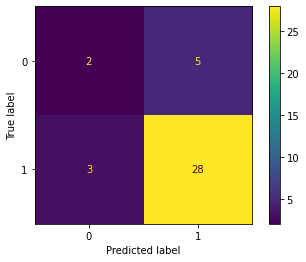

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X_stage, y_is_stage_3, test_size=0.3, random_state=42)

exp_data = train_and_eval_model(X_train, X_test, y_train, y_test, monitor_stage["Stage"].model)

y_pred = exp_data.y_pred
y_test = exp_data.y_test
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

### train no search with cm

In [61]:
monitor_stage_fixed = {}

model = XGBClassifier(n_estimators=5, max_depth=3, learning_rate=1)

X_train, X_test, y_train, y_test = train_test_split(X_stage, y_is_stage_3, test_size=0.3, random_state=42)

monitor_stage_fixed["Stage"] = train_and_eval_model(X_train, X_test, y_train, y_test, model)

generate_datasets_summerization(monitor_stage)

,1_y_train,0_y_train,1_y_test,0_y_test,1_y_pred,0_y_pred,precision_report,recall_report,f1-score_report,support_report,accuracy_report,precision_baseline,recall_baseline,f1-score_baseline,support_baseline,accuracy_baseline,model,extra
Stage,78,22,20,5,21,4,0.809524,0.85,0.829268,20.0,0.72,0.85,0.85,0.85,20.0,0.76,"LogisticRegression(C=0.022238791021191934, sol...",


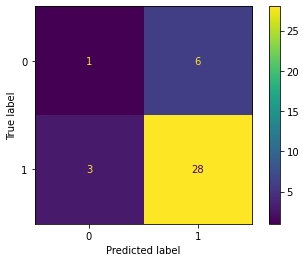

In [62]:
y_pred = monitor_stage_fixed["Stage"].y_pred
y_test = monitor_stage_fixed["Stage"].y_test
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

In [63]:
import shap

def print_shap_plots(model, X):
    try: # tree
        explainer = shap.TreeExplainer(model)
        # shap_values = explainer(X)
        # shap.plots.beeswarm(explanation)
        # shap.plots.bar(explanation)
    except:
        explainer = shap.Explainer(model, X)
    shap_values = explainer(X)
    shap.plots.beeswarm(shap_values)
    shap.plots.bar(shap_values, max_display=8)
    return shap_values



/home/labs/amit/noamsh/.conda/envs/sc_clustering_noam/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning:

[22:31:49] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.



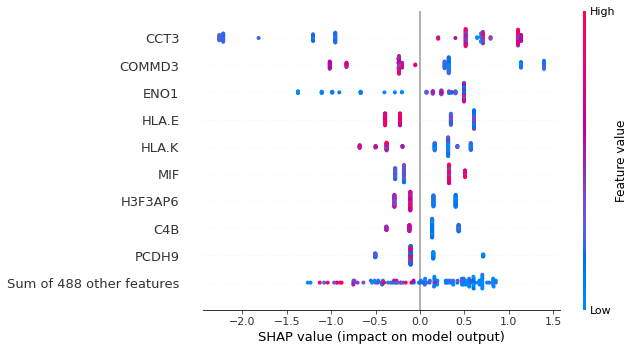

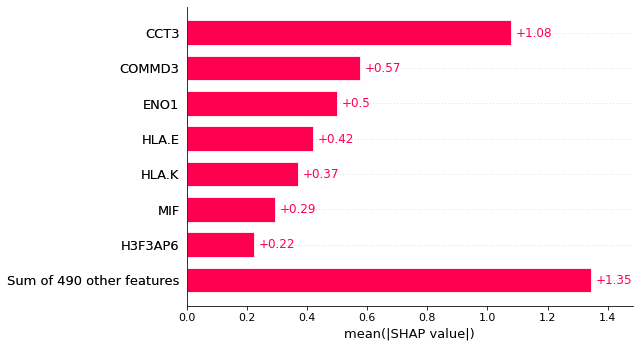

In [64]:
_ = print_shap_plots(monitor_stage_fixed["Stage"].model, X_stage)

In [65]:
FP = y_test[(y_test==0).values & (y_pred==1).values] 
y_stage.loc[FP.index]

PID
HMC17    2.0
TLV15    2.0
TLV26    1.0
TLV59    2.0
HMC09    0.0
TLV53    2.0
Name: Stage, dtype: float64

### FINAL EVALUATAION

In [66]:
def bootstap_model_metric_distribution(model, X, y, n_samples, metric_name="f1-score"):
    baseline_f1_list = []
    model_f1_list = []
    for i in tqdm(range(n_samples)):
        X_train, X_test, y_train, y_test = train_test_split(X_stage, y_is_stage_3, test_size=0.3, random_state=42+i)
        exp_data = train_and_eval_model(X_train, X_test, y_train, y_test, model)
        model_f1_list.append(exp_data.report["1"][metric_name])
        baseline_f1_list.append(exp_data.report["baseline"]["1"][metric_name])
    return model_f1_list, baseline_f1_list

In [67]:
def build_f1_df(model_f1_list, baseline_f1_list, contranst_name, metric_name):
    f1_df = pd.DataFrame({"method":["model"] * len(model_f1_list) + ["baseline - random"] * len(baseline_f1_list),
                      metric_name :model_f1_list + baseline_f1_list})
    f1_df["contrast"] = contranst_name
    return f1_df

In [68]:
f1_dfs = []
metric_name = "accuracy" # recall, precision, f1-score, accuracy
n_samples = 20
for treatment in good_treatments_data_sets:
    # for treatment, exp_data in monitor.items():
    exp_data = monitor[treatment]
    best_model = exp_data.model
    X = pd.concat([exp_data.X_train, exp_data.X_test], axis=0)
    y = pd.concat([exp_data.y_train, exp_data.y_test], axis=0)
    
    model_f1_list, baseline_f1_list = bootstap_model_metric_distribution(best_model, X, y, n_samples=n_samples, metric_name=metric_name)
    
    f1_dfs.append(build_f1_df(model_f1_list, baseline_f1_list, treatment, metric_name))

model_stage = monitor_stage["Stage"].model
# model_f1_list, baseline_f1_list = bootstap_model_metric_distribution(XGBClassifier(n_estimators=10, max_depth=3, learning_rate=1),
#                                                                  X_stage, y_is_stage_3, n_samples=n_samples, metric_name=metric_name)
model_f1_list, baseline_f1_list = bootstap_model_metric_distribution(model_stage,
                                                                 X_stage, y_is_stage_3, n_samples=n_samples, metric_name=metric_name)
f1_dfs.append(build_f1_df(model_f1_list, baseline_f1_list, "Stage", metric_name))
f1_df = pd.concat(f1_dfs, axis=0)

 30%|███       | 6/20 [00:00<00:02,  6.83it/s]/home/labs/amit/noamsh/.conda/envs/sc_clustering_noam/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/labs/amit/noamsh/.conda/envs/sc_clustering_noam/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/labs/amit/noamsh/.conda/envs/sc_clustering_noam/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

 55%|█████▌    | 11/20 [00:01<00:01,  7.31it/s]/hom

In [69]:
list(monitor.keys())

['Bortezomib',
 'Carfilzomib',
 'Lenalidomide',
 'Pomalidomide',
 'DARA',
 'Triple.Ref',
 'IMiD.Resistance.Len.Pom.Thali',
 'PI.Resistance.Bort.Carf.Ixa']

In [70]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

all_types = { 
    "treatments" : ['Bortezomib', 'DARA', 'Lenalidomide', 'Pomalidomide', 'Carfilzomib'],
    "treatments_groups": ['IMiD.Resistance.Len.Pom.Thali', 'Triple.Ref', 'PI.Resistance.Bort.Carf.Ixa'],
    "stage": ["Stage"]
}

widths = {
    "treatments" : 800,
    "treatments_groups": 600,
    "stage": 400
}

for key in all_types:
    f1_df_parial = f1_df[f1_df["contrast"].apply(lambda x: x in all_types[key])]
    fig = px.box(f1_df_parial, color="method", x="contrast" ,y=metric_name, points="all",  width=widths[key], height=600, title = "method sensetivity") 
    # fig.add_trace(go.Box(f1_df, color="method", x="contrast" ,y=metric_name,  width=800, height=600, title = "method sensetivity"), row=1, col=1)
    fig.update(layout_yaxis_range = [0.45,0.95])
    fig.update_layout(
        # template='plotly_dark',
        plot_bgcolor='rgba(0, 0, 0, 0)',
        paper_bgcolor='rgba(0, 0, 0, 0)',
    )
    fig.show()

In [71]:
print(monitor.keys())
[exp_data.model for exp_data in monitor.values()]

dict_keys(['Bortezomib', 'Carfilzomib', 'Lenalidomide', 'Pomalidomide', 'DARA', 'Triple.Ref', 'IMiD.Resistance.Len.Pom.Thali', 'PI.Resistance.Bort.Carf.Ixa'])


[LogisticRegression(C=5.502004429600403, solver='liblinear'),
 XGBClassifier(base_score=None, booster='dart', callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=3, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=9, n_jobs=None,
               num_parallel_tree=None, random_state=None, ...),
 LogisticRegression(C=1.02625866098346, penalty='l1', solver='liblinear'),
 LogisticRegression(C=5.505053338271812, penalty='l1', solver='liblinear'),
 LogisticRegression(C

In [81]:
treatment_shap = 'Carfilzomib'
# print_shap_plots(monitor[treatment_shap].model, monitor[treatment_shap].X_train)
# exp_data = train_and_eval_model(X_train, X_test, y_train, y_test, model, extra_for_report=best_trial.params)
model, X = monitor[treatment_shap].model, monitor[treatment_shap].X_train
# model = XGBClassifier(n_estimators=5,  max_depth=3, learning_rate=1).fit(X, monitor[treatment_shap].y_train)

# explainer = shap.Explainer(model, X)
# shap_values = explainer(X)
# shap.summary_plot(shap_values, X)
shap_values = print_shap_plots(model, X)
# shap.plots.scatter(shap_values.values[:, "CD48"])

/home/labs/amit/noamsh/.conda/envs/sc_clustering_noam/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning:

[22:46:17] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.



TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=9, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
[col for col in X.columns if "CD" in col]

## predict stage scores per patient

In [ ]:
model = monitor_stage["Stage"].model
X = X_stage
y = y_is_stage_3

y_pred = {}
for pid in y.index:
    X_train = X.drop(pid)
    y_train = y.drop(pid)
    model.fit(X_train, y_train)
    X_pred = X.loc[pid]
    proba_ref = model.predict_proba(pd.DataFrame(X_pred).T)[0][1]
    y_pred[pid] = proba_ref

y_proba_pred = pd.Series(y_pred)
y_proba_pred.hist()

### train STAGES WHITH 0 AND 1 Combibed

In [ ]:
predictions_df = pd.concat([dataset["Stage"] , y_proba_pred], axis = 1)
predictions_df[predictions_df["Stage"] == 3][0].hist()
predictions_df.to_excel("predictions.xlsx")

In [ ]:
# monitor_stage = {}

# model = XGBClassifier(n_estimators=10, max_depth=3, learning_rate=1)

# X_train, X_test, y_train, y_test = train_test_split(X_stage, y_0_is_1, test_size=0.3, random_state=42)
# monitor_stage["Stage"] = train_and_eval_model(X_train, X_test, y_train, y_test, model)

# monitor_stage["Stage"].report

In [ ]:

# y_pred = monitor_stage["Stage"].y_pred
# y_test = monitor_stage["Stage"].y_test
# cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
# disp.plot()
# plt.show()